In [1]:
import findspark
findspark.init('/home/hdoop/Downloads/spark')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, log1p, expm1, instr, lit, udf, array, sum, avg, max, min, mean, stddev, countDistinct, desc, asc, monotonically_increasing_id
from pyspark.sql import DataFrame

In [3]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [4]:
spark = SparkSession.builder.appName('RecommendationModel').getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions","5")

24/05/09 23:47:15 WARN Utils: Your hostname, emad resolves to a loopback address: 127.0.1.1; using 192.168.100.2 instead (on interface wlp1s0)
24/05/09 23:47:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 23:47:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read Data ###

In [5]:
schema= StructType([
    # StructField("_id", StringType(), True),
    StructField("track_id", IntegerType(), True),
    StructField("track_title", StringType(), True),
    StructField("track_genre_top", StringType(), True),
    StructField("track_listens", IntegerType(), True),
    StructField("track_favorites", IntegerType(), True),
    StructField("album_title", StringType(), True),
    StructField("album_listens", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    # StructField("trackID", StringType(), True),
    # StructField("file_path", StringType(), True),
    #StructField("mfcc_features", ArrayType(FloatType()), True)
])


In [6]:
sc= spark.sparkContext
# connecting to MongoDB
client= MongoClient('mongodb://localhost:27017')
mongo_database= client['AudioFeatures']
collection_name= mongo_database['features_collection']
read_data= collection_name.find()
tracks_rdd= sc.parallelize(list(read_data))

In [7]:
audio_df= spark.createDataFrame(tracks_rdd, schema)

In [8]:
audio_df.printSchema()

root
 |-- track_id: integer (nullable = true)
 |-- track_title: string (nullable = true)
 |-- track_genre_top: string (nullable = true)
 |-- track_listens: integer (nullable = true)
 |-- track_favorites: integer (nullable = true)
 |-- album_title: string (nullable = true)
 |-- album_listens: integer (nullable = true)
 |-- artist_name: string (nullable = true)



### Data Cleaning(EDA and Processing) ###

In [9]:
# filtering those tracks which have more than 10 listens and less than 1000 listens
filtered_tracks= audio_df.filter((audio_df['track_listens'] >= 5) & (audio_df['track_listens'] <= 1000))

In [10]:
spark.conf.set("spark.mongodb.input.batchSize.perDocument", 50)
filtered_tracks.show()

24/05/09 23:47:33 WARN TaskSetManager: Stage 0 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+---------------+-------------+---------------+--------------------+-------------+--------------------+
|track_id|         track_title|track_genre_top|track_listens|track_favorites|         album_title|album_listens|         artist_name|
+--------+--------------------+---------------+-------------+---------------+--------------------+-------------+--------------------+
|       3|        Electric Ave|        Hip-Hop|          514|              1|AWOL - A Way Of Life|         6073|                AWOL|
|     134|        Street Music|        Hip-Hop|          943|              3|AWOL - A Way Of Life|         6073|                AWOL|
|     138|              Side B|   Experimental|          489|              2|        Live at LACE|         1681|              Airway|
|     139|            CandyAss|           Folk|          582|              3|Every Man For Him...|         1304|Alec K. Redfearn ...|
|     141|                Ohio|           Folk|          725| 

In [11]:
filtered_tracks_df= filtered_tracks.sample(withReplacement= False, fraction= 0.01, seed= 40).toPandas()

24/05/09 23:47:37 WARN TaskSetManager: Stage 1 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.


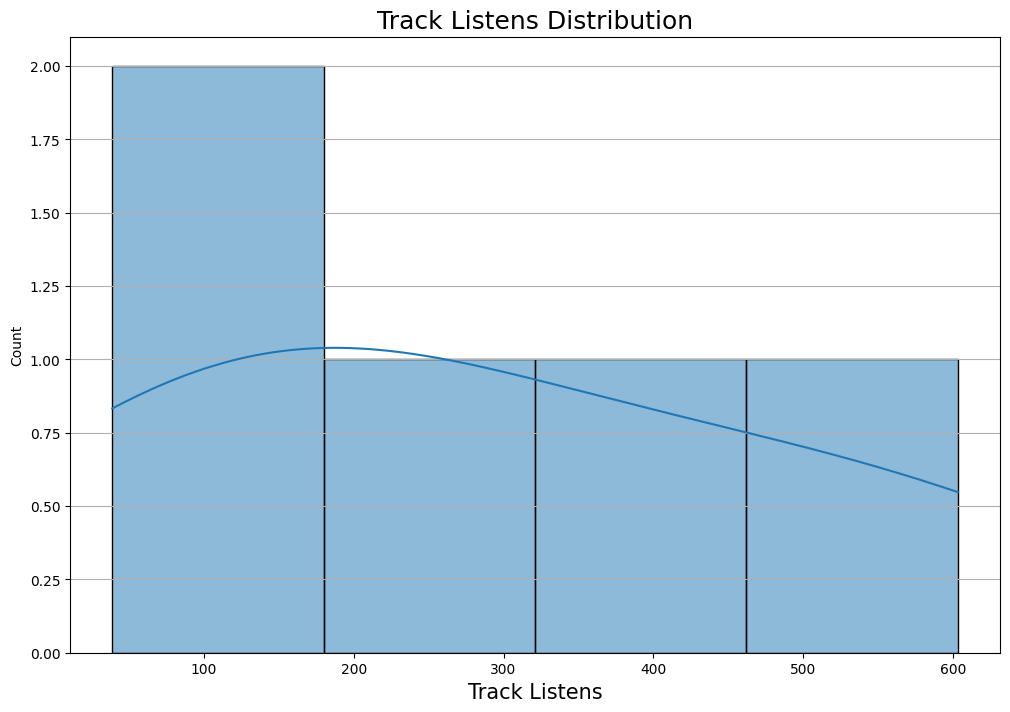

In [12]:
# plotting the distribution of track listens
plt.figure(figsize= (12, 8))
sns.histplot(data= filtered_tracks_df, x= "track_listens", kde= True)
plt.grid(which= 'major', axis= 'y')
plt.xlabel('Track Listens', size= 15)
plt.title('Track Listens Distribution', size= 18)
plt.show()

In [13]:
# checking for null values
null_count= filtered_tracks.select([count(when(isnan(cols), cols)).alias(cols) for cols in audio_df.columns]).collect()[0]
null_count

24/05/09 23:47:42 WARN TaskSetManager: Stage 2 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.


Row(track_id=0, track_title=0, track_genre_top=0, track_listens=0, track_favorites=0, album_title=0, album_listens=0, artist_name=0)

In [14]:
# we can further clean our data to filter out repeating artists
filtered_tracks.createOrReplaceTempView('artist_name')
distinct_artists= spark.sql("SELECT * FROM artist_name WHERE artist_name LIKE 'Area%'")

In [15]:
distinct_artists.show()

24/05/09 23:47:50 WARN TaskSetManager: Stage 5 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 23:47:50 WARN TaskSetManager: Stage 6 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 23:47:51 WARN TaskSetManager: Stage 7 contains a task of very large size (28727 KiB). The maximum recommended task size is 1000 KiB.
24/05/09 23:47:51 WARN TaskSetManager: Stage 8 contains a task of very large size (27598 KiB). The maximum recommended task size is 1000 KiB.


+--------+-----------+---------------+-------------+---------------+--------------------+-------------+-----------+
|track_id|track_title|track_genre_top|track_listens|track_favorites|         album_title|album_listens|artist_name|
+--------+-----------+---------------+-------------+---------------+--------------------+-------------+-----------+
|     156|   Track 01|   Experimental|          362|              2|Thee Haunted Cobb...|         1845|     Area C|
|     157|   Track 02|   Experimental|          190|              1|Thee Haunted Cobb...|         1845|     Area C|
|     158|   Track 03|   Experimental|          163|              1|Thee Haunted Cobb...|         1845|     Area C|
|     159|   Track 04|   Experimental|          130|              1|Thee Haunted Cobb...|         1845|     Area C|
|     160|   Track 05|   Experimental|          110|              0|Thee Haunted Cobb...|         1845|     Area C|
|     161|   Track 06|   Experimental|          121|              0|Thee

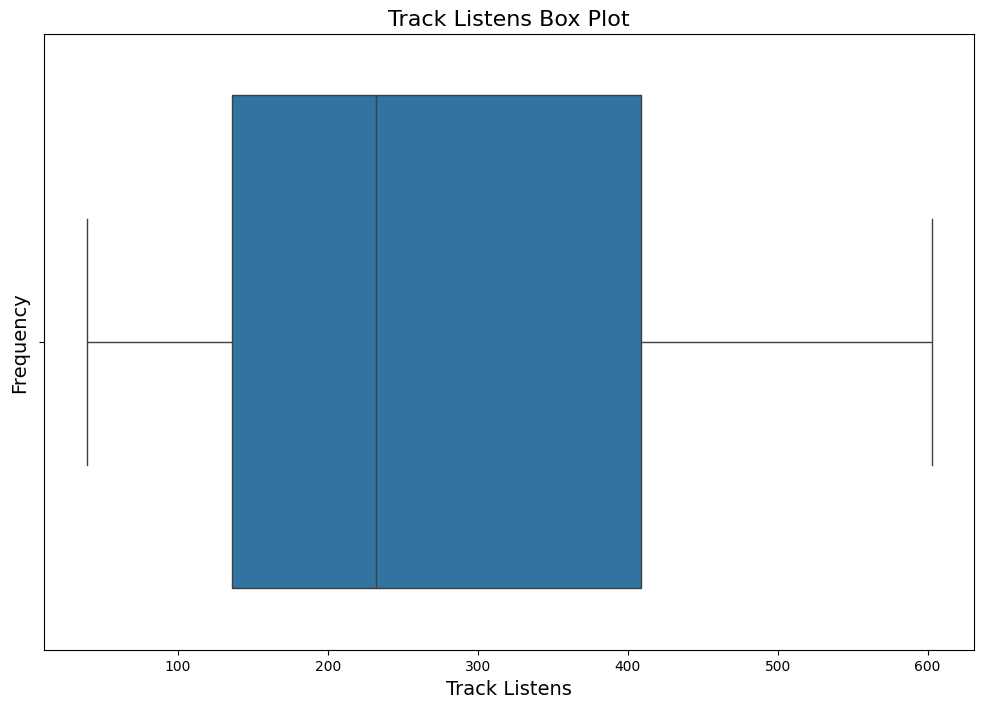

In [16]:
# plotting a box plot to show the skewness of track listens
plt.figure(figsize= (12, 8))
sns.boxplot(x= filtered_tracks_df['track_listens'])
plt.title('Track Listens Box Plot', size= 16)
plt.xlabel('Track Listens', size= 14)
plt.ylabel('Frequency', size= 14)
plt.show()

Since the data is right skewed, we will use log transformation on our target variable.

In [17]:
filtered_tracks= filtered_tracks.withColumn('transformed_listens', log1p('track_listens'))

In [18]:
filtered_tracks_df= filtered_tracks.sample(withReplacement= False, fraction= 0.01, seed= 40).toPandas()

24/05/09 23:47:56 WARN TaskSetManager: Stage 9 contains a task of very large size (28729 KiB). The maximum recommended task size is 1000 KiB.


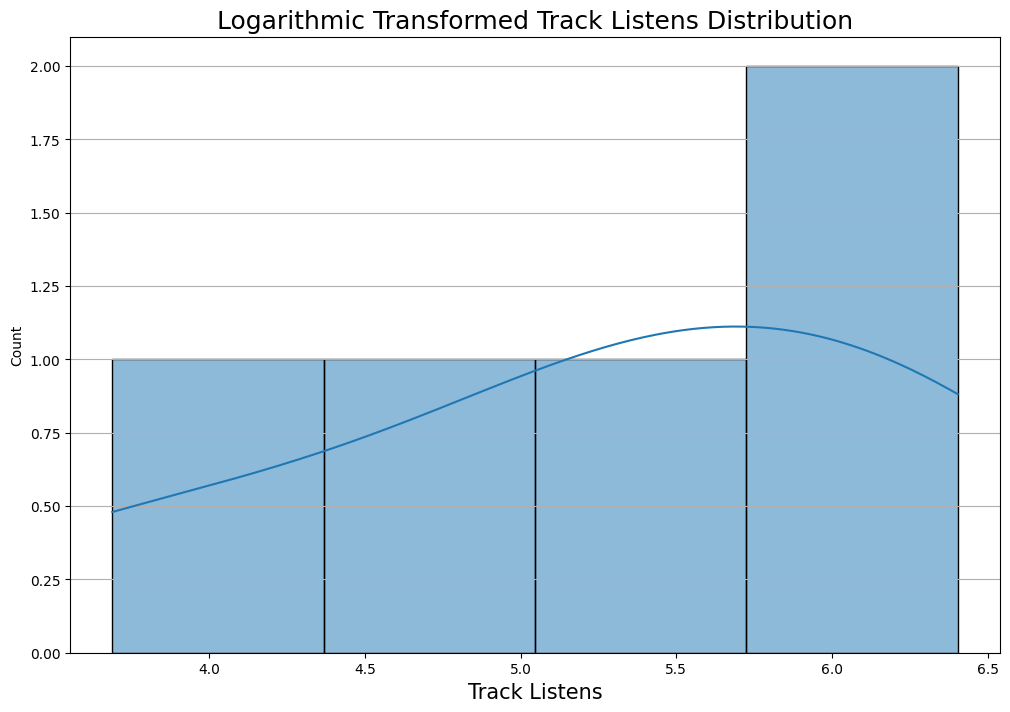

In [19]:
# plotting the distribution of transformed track listens
plt.figure(figsize= (12, 8))
sns.histplot(data= filtered_tracks_df, x= 'transformed_listens', kde= True)
plt.grid(which= 'major', axis= 'y')
plt.xlabel('Track Listens', size= 15)
plt.title('Logarithmic Transformed Track Listens Distribution', size= 18)
plt.show()

Now that we have tried to lower the bias as much as we could by cleaning the data and transforming it, we can move to model training.

### Model Training and Testing ###

In [20]:
train_data, test_data= filtered_tracks.randomSplit([0.8, 0.2], seed= 40) # 80-20 split for training and testing data

In [21]:
spark.stop()